In [1]:
from glm_utils.preprocessing import time_delay_embedding, BasisProjection
import glm_utils.bases
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as lm
import scipy.signal
from demo_utils import get_data
plt.style.use('ncb.mplstyle')

# Priority list:
# TODO: add train-test split.
# TODO: add plot comparing "relevance" of each input to the model (compare coefficients/filter-magnitudes).
# TODO: add an example with irrelevant features for choice of features.
# TODO: add an example for redundant variables.
# TODO: show problems of not normalizing your inputs in a separate box.

# Enhancements list:
# TODO: add an "observe your data" box in the first steps, to show how to examine what kind of data you have (histograms and feature vs signal scatter plot, looking for clear linear relationships, or to see what kind of transformation to apply to the features to make them more relevant, e.g. absolute value).
# TODO: fix 'estimated' and 'true' labels for overlapped filters graph
# TODO: add option for noise in get_data.


# Get data

(2000, 4) (2000,) (50, 4)


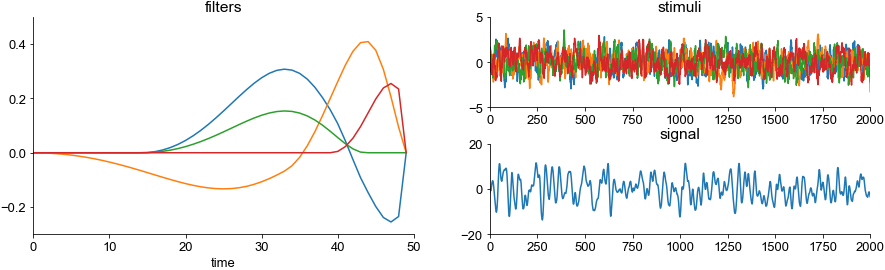

In [28]:

x, y, filters = get_data()

npoints, ninputs = x.shape

print(x.shape, y.shape, filters.shape)
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(filters)
plt.title('filters')
plt.xlabel('time')
plt.subplot(222)
plt.plot(x)
plt.title('stimuli')
plt.subplot(224)
plt.plot(y)
plt.title('signal')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Define a basis

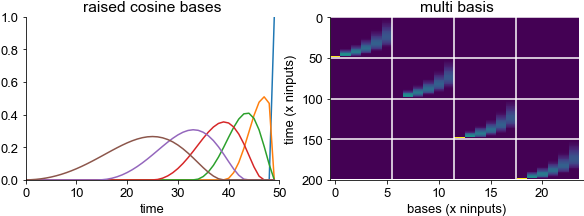

In [3]:
# define bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

plt.figure(figsize = [10,3])
plt.subplot(121)
plt.plot(B)
plt.title('raised cosine bases')
plt.xlabel('time')

plt.subplot(122) # more info on this plot, such as better axis and division labels
plt.imshow(B_multi)
plt.hlines(np.arange(0, ninputs*window_size,window_size), -0.5, B_multi.shape[1], colors='w')
plt.vlines(np.arange(0, ninputs*nbases,nbases)-0.5, 0, B_multi.shape[0], colors='w')
plt.axis('tight')
plt.ylabel('time (x ninputs)')
plt.xlabel('bases (x ninputs)')
plt.title('multi basis')
plt.show()

# Sample

In [4]:
# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)


# Train

In [5]:
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('score:',lr.score(Xmulti_b, ymulti))

score: 1.0


# Filter reconstruction

Text(0.5, 1.0, 'filters')

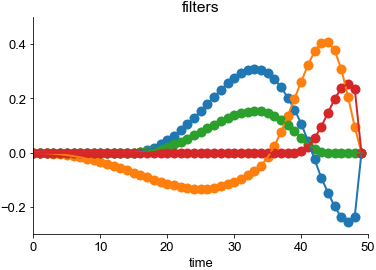

In [7]:
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')

# With noise

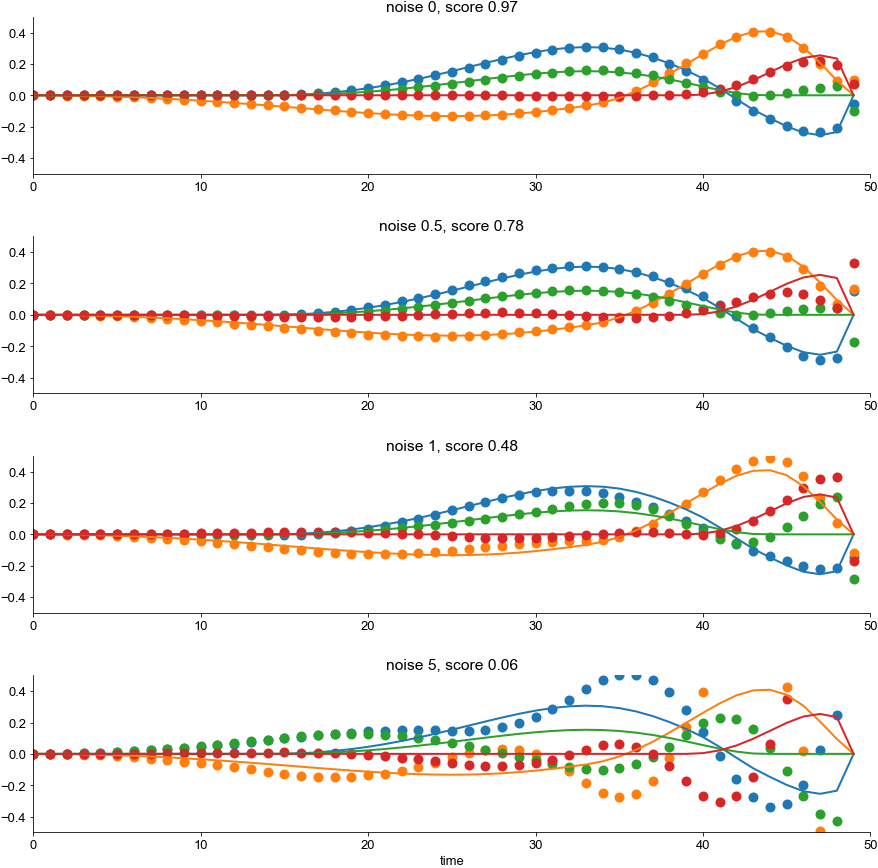

In [18]:
noise_levels = [0,0.5,1,5]
plt.figure(figsize=[15,15])
for ii, noise_level in enumerate(noise_levels):
    plt.subplot(len(noise_levels),1,ii+1)

    y_noisy = ymulti + np.random.normal(ymulti.mean(), ymulti.std(), ymulti.shape[0])*noise_level # add noise to signal

    # train
    lr = lm.LinearRegression()
    lr.fit(Xmulti_b, y_noisy)

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
    estimated_filters = np.squeeze(estimated_filters)

    # plot
    for ii in range(ninputs):
        plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
    plt.ylim([-0.5,0.5])
    plt.gca().set_prop_cycle(None)
    plt.plot(filters, linewidth=2)
    plt.title(f'noise {noise_level}, score {lr.score(Xmulti_b, y_noisy):0.2f}')
plt.xlabel('time')
plt.subplots_adjust(hspace=0.4)
plt.show()

# Incomplete inputs

score: 0.8806919943313195


Text(0.5, 1.0, 'filters')

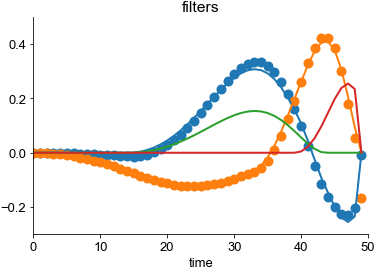

In [19]:
# data
x, y, filters = get_data()
x = x[:,:2] # remove one of the original inputs
npoints, ninputs = x.shape

# bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)

# train
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('score:',lr.score(Xmulti_b, ymulti))

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

# plot
for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')

# Irrelevant features

score: 1.0


Text(0.5, 1.0, 'filters')

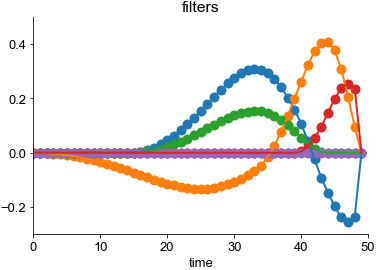

In [22]:
# data
x, y, filters = get_data()
x = np.concatenate((x,np.random.normal(0, 1, x[:,0].shape)[:,np.newaxis]),axis=1) # add a normaly distributed variable
npoints, ninputs = x.shape

# bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)

# train
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('score:',lr.score(Xmulti_b, ymulti))

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

# plot
for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters')

# Redundant features

lr score: 1.0
lasso score: 0.9446722555506623


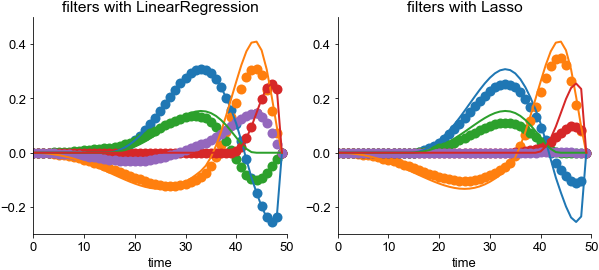

In [26]:
# data
x, y, filters = get_data()
x = np.concatenate((x,x[:,[1]]+x[:,[2]]),axis=1)
x[:,-1] = (x[:,-1] - np.mean(x[:,-1]))/np.std(x[:,-1]) # normalize new feature
npoints, ninputs = x.shape

# bases
B = glm_utils.bases.raised_cosine(1, 5, [1, 23], 9)
B_multi = glm_utils.bases.multifeature_basis(B, ninputs)  # should explain what/why we do this here
basis_multi_projection = BasisProjection(B_multi)  # should explain what/why we do this here
window_size, nbases = B.shape

# time-delay-embedding
Xmulti, ymulti = time_delay_embedding(x, y, window_size=window_size, flatten_inside_window=True)

# choose how many random samples to take from the data (less or equal than the available data, npoints)
nsamples = 1000
sample_idxs = np.random.choice(np.arange(ymulti.shape[0]),nsamples,replace=False)

# sample
Xmulti = Xmulti[sample_idxs]
ymulti = ymulti[sample_idxs]

# project
Xmulti_b = basis_multi_projection.transform(Xmulti)

# train
lr = lm.LinearRegression()
lr.fit(Xmulti_b, ymulti)
print('lr score:',lr.score(Xmulti_b, ymulti))

# train (with lasso)
lr_lasso = lm.Lasso()
lr_lasso.fit(Xmulti_b, ymulti)
print('lasso score:',lr_lasso.score(Xmulti_b, ymulti))

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = np.squeeze(estimated_filters)    # inverse transform returns a [1, ncoefs] array

# reconstruct (with lasso)
basis_weights_lasso = lr_lasso.coef_
estimated_filters_lasso = basis_multi_projection.inverse_transform(basis_weights_lasso)
estimated_filters_lasso = np.squeeze(estimated_filters_lasso)    # inverse transform returns a [1, ncoefs] array

# plot
plt.figure(figsize =[10,4])
plt.subplot(121)
for ii in range(ninputs):
    plt.plot(estimated_filters[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters with LinearRegression')
plt.subplot(122)
for ii in range(ninputs):
    plt.plot(estimated_filters_lasso[ii*window_size:(ii+1)*window_size], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(filters, linewidth=2)
plt.xlabel('time')
plt.title('filters with Lasso')
plt.show()